# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI model learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard version of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

     |████████████████████████████████| 69 kB 4.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.4 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 242 kB 13.9 MB/s 
     |████████████████████████████████| 211 kB 93.2 MB/s 
     |████████████████████████████████| 678 kB 89.1 MB/s 
     |████████████████████████████████| 813 kB 72.5 MB/s 
     |████████████████████████████████| 127 kB 92.4 MB/s 
     |████████████████████████████████| 2.0 MB 68.6 MB/s 
     |████████████████████████████████| 8.8 MB 32.3 MB/s 
     |████████████████████████████████| 1.4 MB 70.0 MB/s 
     |████████████████████████████████| 41 kB 134 kB/s 
     |█████████████

In [2]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi

%matplotlib inline

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Initialization
Load data and select the top 1000 variable genes with seurat_v3 method

In [3]:
save_path = 'data'
adata = sc.read(os.path.join(save_path, "pbmc_10k_protein_v3.h5ad"), backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true")

adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='counts', n_top_genes=1000, subset=True)

  0%|          | 0.00/23.8M [00:00<?, ?B/s]

## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [4]:
# setup the anndata for scvi-tools
scvi.model.LinearSCVI.setup_anndata(adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 6855 cells, 1000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [5]:
# initialize LinearSCVI model
model = scvi.model.LinearSCVI(adata, n_latent=10)

In [6]:
# train for 250 epochs, compute metrics every 10 epochs
model.train(max_epochs=250, plan_kwargs={'lr':5e-3}, check_val_every_n_epoch=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████| 250/250 [01:53<00:00,  2.20it/s, loss=373, v_num=1]


Inspecting the convergence

In [7]:
train_elbo = model.history['elbo_train'][1:]
test_elbo = model.history['elbo_validation']

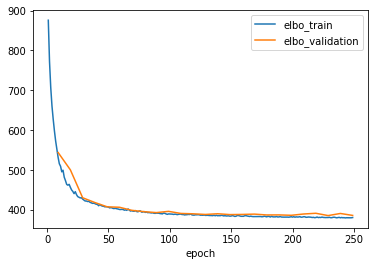

In [8]:
ax = train_elbo.plot()
test_elbo.plot(ax = ax)

## Extract and plot latent dimensions for cells

From the fitted model we extract the (mean) values for the latent dimensions. We store the values in the AnnData object for convenience.

In [9]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f'Z_{i}'] = z

Now we can plot the latent dimension coordinates for each cell. A quick (albeit not complete) way to view these is to make a series of 2D scatter plots that cover all the dimensions. Since we are representing the cells by 10 dimensions, this leads to 5 scatter plots.

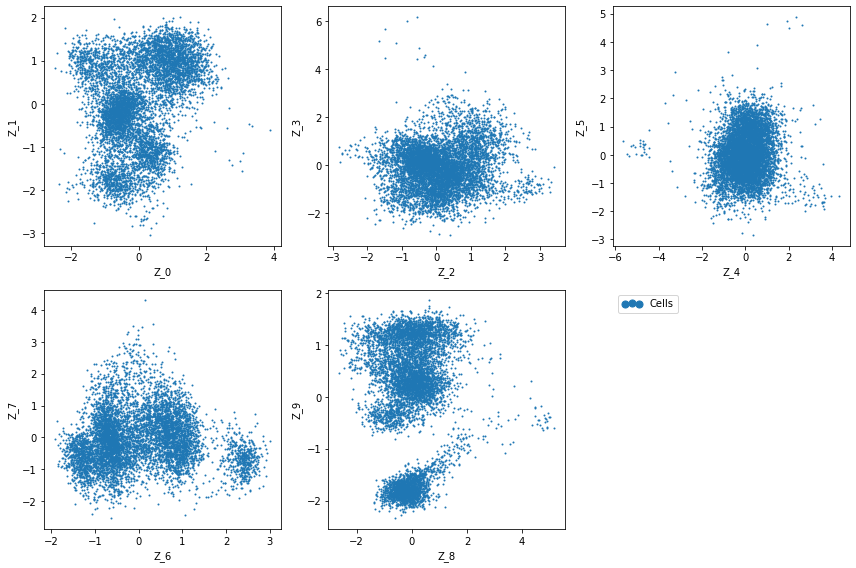

In [10]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', s=4, label='Cells')

    plt.xlabel(f'Z_{f}')
    plt.ylabel(f'Z_{f + 1}')

plt.subplot(2, 3, 6)    
plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', label='Cells', s=4)
plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], c='w', label=None)
plt.gca().set_frame_on(False)
plt.gca().axis('off')

lgd = plt.legend(scatterpoints=3, loc='upper left')
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()

The question now is how does the latent dimensions link to genes?

For a given cell x, the expression of the gene g is proportional to x_g = w_(1, g) * z_1 + ... + w_(10, g) * z_10. Moving from low values to high values in z_1 will mostly affect expression of genes with large w_(1, :) weights. We can extract these weights from the `LDVAE` model, and identify which genes have high weights for each latent dimension.

In [11]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
index,,,,,,,,,,
AL645608.8,0.489869,0.192129,0.257994,-0.233664,0.375783,-0.484236,-0.031739,-0.600958,0.150751,-0.170000
HES4,0.538178,-0.108243,0.574299,-0.691867,0.271781,-0.267163,0.125954,-0.337102,0.135615,-0.195103
ISG15,0.548381,0.333567,0.295555,-0.328541,-0.127009,-0.086488,0.159463,-0.079988,-0.029837,0.413857
TNFRSF18,0.326834,0.199915,1.183382,0.086755,-0.574726,-0.182124,0.407528,-0.415888,0.333520,1.925462
TNFRSF4,0.664630,0.633825,1.084824,-0.097593,-0.656927,-0.417250,0.539613,-0.142947,0.097591,1.477943


For every latent variable Z, we extract the genes with largest _magnitude_, and separate genes with large negative values from genes with large positive values. We print out the top 5 genes in each direction for each latent variable.

In [12]:
print('Top loadings by magnitude\n---------------------------------------------------------------------------------------')
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ':\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.head(5).index])
    fstr += '\n\t...\n\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.tail(5).index])
    print(fstr + '\n---------------------------------------------------------------------------------------\n')

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	PTGS2, -1.1	GZMK, -1.0	CD1E, -0.97	IL1B, -0.96	EGR3, -0.82
	...
	RRM2, 1.4	TSHZ2, 1.4	AC007240.1, 1.4	MYLK3, 1.5	FOXP3, 1.6
---------------------------------------------------------------------------------------

Z_1:	HLA-DQA1, -1.1	HLA-DQA2, -1.0	C1QA, -0.91	HLA-DRB5, -0.83	HLA-DRB1, -0.8
	...
	NELL2, 1.7	TRAV4, 1.7	CD8A, 1.9	IL7R, 1.9	CD8B, 2.2
---------------------------------------------------------------------------------------

Z_2:	CD8A, -1.1	LINC02446, -1.1	CD8B, -1.0	MIR4432HG, -0.88	IGLV1-51, -0.83
	...
	C1QC, 1.3	RTKN2, 1.4	LMNA, 1.4	C1QA, 1.4	IFI27, 1.8
---------------------------------------------------------------------------------------

Z_3:	S100B, -1.8	C1QB, -1.6	C1QA, -1.5	TRDC, -1.5	KLRC2, -1.4
	...
	SDR16C5, 0.73	OSTN-AS1, 0.79	COCH, 0.82	TNFRSF13B, 0.86	SSPN, 0.88
-------------------------------------------------------------------------------------

It is important to keep in mind that unlike traditional PCA, these latent variables are not ordered. Z_0 does not necessarily explain more variance than Z_1.

These top genes can be interpreted as following most of the structural variation in the data.

The `LinearSCVI` model further supports the same scVI functionality as the `SCVI` model, so all posterior methods work the same. Here we show how to use scanpy to visualize the latent space.

In [13]:
adata.obsm["X_scVI"] = Z_hat
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

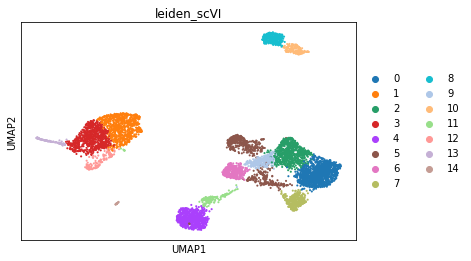

In [14]:
sc.pl.umap(adata, color=["leiden_scVI"])

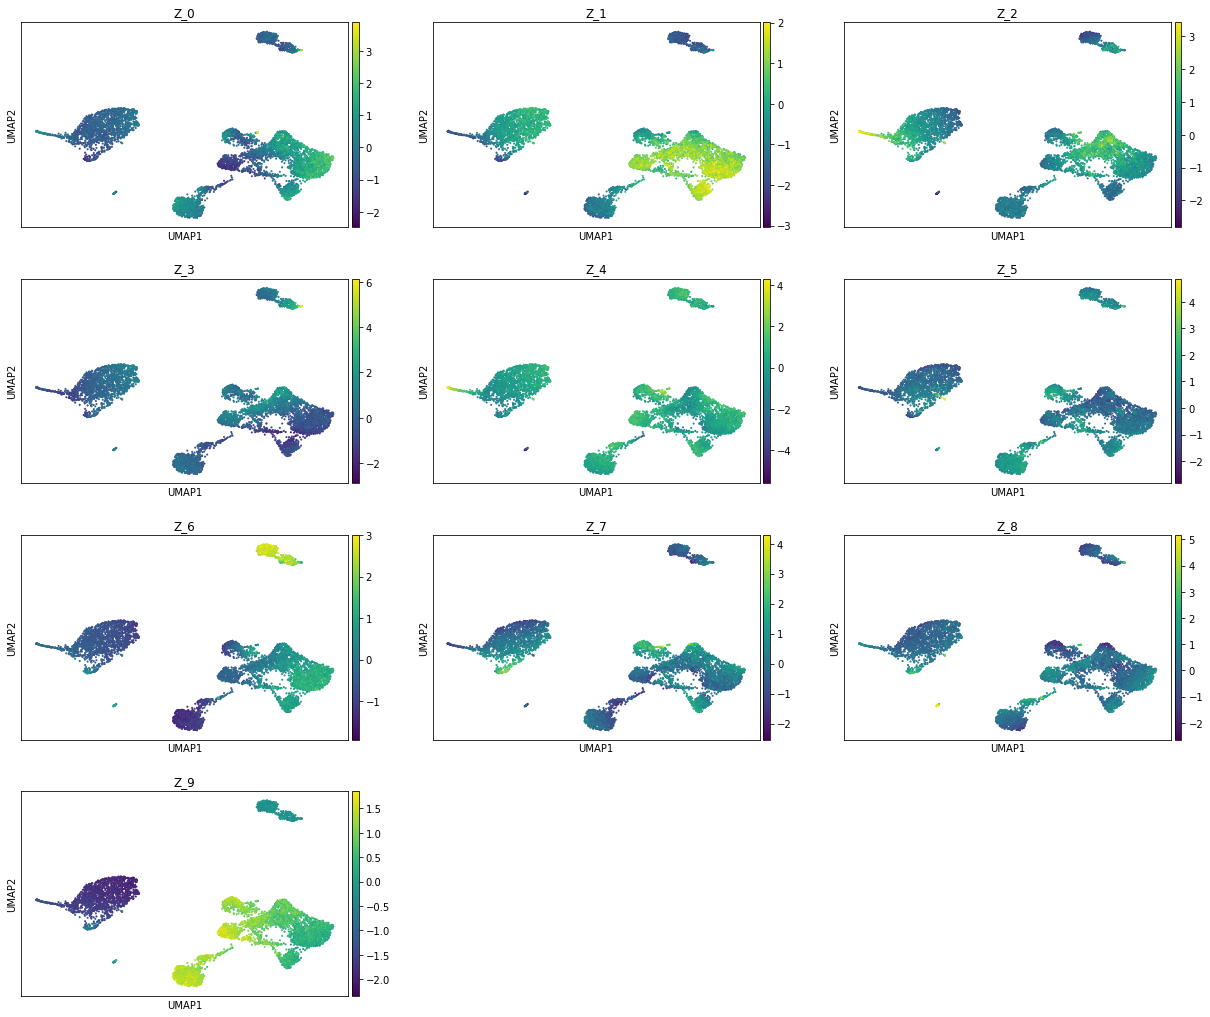

In [15]:
zs = [f'Z_{i}' for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3)